In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from IPython.display import Image

from typing import TypedDict, Annotated, Dict, Any
import operator
import json

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    output: Dict[str, Any]

In [4]:
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool
import requests

search_url = "https://s.jina.ai/"
read_url = "https://r.jina.ai/"

class SearchInput(BaseModel):
    query: str = Field(description="should be a search query")

class ReadInput(BaseModel):
    url: str = Field(description="should be a website URL")

@tool("search-tool", args_schema=SearchInput, return_direct=True)
def search_tool(query: str) -> str:
    """Search a query online and output the markdown"""
    return requests.get(search_url + query)

@tool("read-tool", args_schema=ReadInput, return_direct=True)
def read_tool(url: str) -> str:
    """Return markdown of given URL, less computationally expensive than the search tool"""
    return requests.get(read_url + url)

In [5]:
tools = [search_tool, read_tool]

In [6]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class Restaurants(BaseModel):
    restaurant: str = Field(description="The name of the restaurant")
    phone_number: str = Field(description="The phone number of the restaurant")
    emails: List[str] = Field(description="The email of the restaurant")
    dietary_offerings: List[str] = Field(description="The dietary options the restaurant offers")
    reviews: List[str] = Field(description="Relevant reviews of the restaurant")

In [8]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_node("output-parser", self.parse_output_to_string)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: "output-parser"}
        )
        graph.add_edge("action", "llm")
        graph.add_edge("output-parser", END)
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def parse_output_to_string(self, state: AgentState):
        message = state['messages'][-1]
        json_output = JsonOutputParser(pydantic_object=Restaurants).invoke(message)
        return {'output': [json_output]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [9]:
prompt = """You are a AI assistant who will help scrape web data to be used in a database. \\
Use the search engine to look up information, and use the read-tool to read from important URLs you find. \\
Gather information such as restaurants, phone numbers, emails, dietary offerings, and customer reviews. \\
You are allowed to make multiple calls (either together or in sequence). \\
Only look up information when you are sure of what you want. \\
If you need to look up some information before asking a follow-up question, you are allowed to do that! \\
Once you are finished looking up information YOU MUST return the data to the user in JSON format! \\
Do not respond to the user as an agent, ONLY return JSON data. \\
"""
model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, tools, system=prompt)

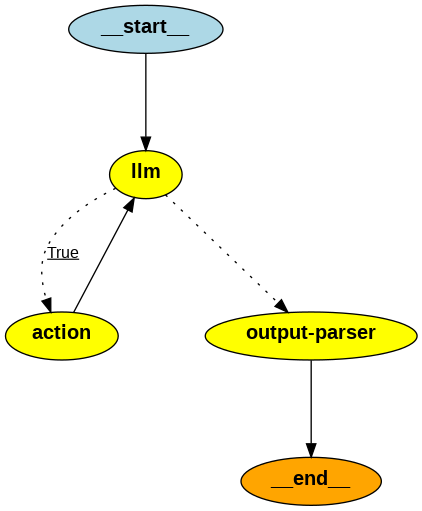

In [11]:
Image(abot.graph.get_graph().draw_png())

In [12]:
messages = [HumanMessage(content="I need low fat foods in Washington D.C.")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'search-tool', 'args': {'query': 'low fat foods restaurants Washington D.C.'}, 'id': 'call_taOeGFb1X5CmnFFXTsClsCuY'}
Back to the model!
Calling: {'name': 'read-tool', 'args': {'url': 'https://www.verywellfit.com/best-healthy-restaurants-in-washington-dc-4147474'}, 'id': 'call_zAjfJG7BKXSqm64MjkcN6YIM'}
Back to the model!


In [13]:
result['output']

[{'restaurants': [{'name': 'Founding Farmers',
    'address': '1924 Pennsylvania Ave NW, Washington, DC 20006',
    'phone': '(202) 822-8783',
    'dietary_offerings': ['low fat', 'vegetarian', 'vegan', 'gluten-free'],
    'reviews': [{'author': 'Jane D.',
      'rating': 5,
      'comment': 'Great variety of healthy options. Loved the low-fat dishes!'},
     {'author': 'John S.',
      'rating': 4,
      'comment': 'Good food but a bit crowded.'}]},
   {'name': 'Sweetgreen',
    'address': 'Multiple locations in Washington D.C.',
    'phone': '',
    'dietary_offerings': ['low fat', 'vegetarian', 'vegan', 'gluten-free'],
    'reviews': [{'author': 'Alice M.',
      'rating': 5,
      'comment': 'Perfect for a healthy and quick lunch. The salads are amazing!'},
     {'author': 'Bob K.',
      'rating': 4,
      'comment': 'Great place for low-fat meals, but a bit pricey.'}]},
   {'name': 'Chaia Tacos',
    'address': '3207 Grace St NW, Washington, DC 20007',
    'phone': '(202) 333-522